In [1]:
import sys
sys.path.append(r"E:\システムトレード入門\tutorials\rl\pfrl")
sys.path.append(r"E:\システムトレード入門\trade_system_git_workspace")

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from collections import namedtuple
import collections

In [3]:
import datetime
from pytz import timezone

In [4]:
from pathlib import Path

In [5]:
from get_stock_price import StockDatabase

In [6]:
import pfrl

In [7]:
from envs_ver3 import OneStockEnv, NormalizeState, NormalizeReward

### データベース 

In [8]:
db_path = Path("E:/システムトレード入門/trade_system_git_workspace/db/stock_db") / Path("stock.db")
stock_db = StockDatabase(db_path)

### 環境の作成 

In [9]:
jst_timezone = timezone("Asia/Tokyo")
start_datetime = jst_timezone.localize(datetime.datetime(2020,11,1,0,0,0))
end_datetime = jst_timezone.localize(datetime.datetime(2020,12,1,0,0,0))
#end_datetime = get_next_workday_jp(start_datetime, days=11)  # 営業日で一週間(5日間)

#stock_names = "4755"
stock_names = "9984"
#stock_names = ["6502","4755"]
#stock_list = ["4755","9984","6701","7203","7267"]

use_ohlc="Close"

In [10]:
initial_cash = 1.e6
initial_unit = 50

freq_str = "5T"
episode_length = 12*5*7  # 1週間

#state_time_list = [0,1,12,12*3,12*5,12*5*3],  # [現在，次時刻，一時間後，3時間後，5時間後(1日後), 15時間後(3日後)]
state_time_list = [0,
                   1,
                   2,
                   6,
                   12,
                   12*2,
                   12*3,
                   12*4,
                   12*5*1,
                   12*5*2,
                   12*5*3,
                   12*5*4,
                   12*5*5,
                   ]  # 現在，5分後, 10分後, 30分後, 1時間後, 2時間後, 3時間後, 4時間後, 1日後, 2日後, 3日後, 4日後, 5日後, 6日後, 7日後

one_unit_stocks = 20
max_units_number = 5
stay_penalty_unit_bound=30


env = OneStockEnv(stock_db,
                  stock_names=stock_names,
                  start_datetime=start_datetime,
                  end_datetime=end_datetime,
                  freq_str="5T",
                  episode_length=episode_length,  # 一週間
                  state_time_list=state_time_list,
                  use_ohlc=use_ohlc,  # 終値を使う
                  initial_cash=initial_cash,  # 種銭：100万円,
                  initial_unit=initial_unit,
                  use_view=False,
                  one_unit_stocks=one_unit_stocks,  # 独自単元数
                  max_units_number=max_units_number,  # 一度に売買できる独自単元数
                  low_limmit=1.e4,  # 全財産がこの値以下になれば終了
                  interpolate=True,
                  stay_penalty_unit_bound=stay_penalty_unit_bound  # このunit数以下の場合のstayはペナルティ
                 )

### transformの作成 

In [11]:
state_transform = NormalizeState(cash_const=initial_cash,
                                 unit_const=100,
                                 price_const=1.e4,
                                )

reward_transform = NormalizeReward(reward_const=5.e3,
                                  )

In [12]:
env.reset()

(StockState(cash=1000000.0, unit_number=50, mean_cost_price=6743.88097466433, all_property=7748000.0, price_array=array([6748., 6747., 6752., 6769., 6760., 6769., 6728., 6959., 7044.,
        6849., 6648., 6681., 6610.])),
 0,
 False,
 {'datetime': datetime.datetime(2020, 11, 6, 10, 40, tzinfo=<DstTzInfo 'Asia/Tokyo' JST+9:00:00 STD>),
  'stock_name': '9984',
  'done_active': None,
  'iter_counter': 1,
  'penalty': 0,
  'gein_reward': 0,
  'price_reward': 0,
  'all_property_reward': 0,
  'reward': 0})

### Q関数の定義 

In [13]:
class QFunction(nn.Module):
    def __init__(self, obs_size, n_actions):
        super().__init__()
        self.fc1 = nn.Linear(obs_size, 32)
        self.bn1 = nn.BatchNorm1d(32)
        
        self.fc2 = nn.Linear(32, 128)
        self.bn2 = nn.BatchNorm1d(128)
        
        self.fc3 = nn.Linear(128, 256)
        self.bn3 = nn.BatchNorm1d(256)
        
        self.fc4 = nn.Linear(256, n_actions)
    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))
        x = F.relu(self.bn2(self.fc2(x)))
        x = F.relu(self.bn3(self.fc3(x)))
        
        x = self.fc4(x)
        out = pfrl.action_value.DiscreteActionValue(x)
        return out

### Q関数の初期化 

In [14]:
obs_size = env.observation_space.low.size
print("observation size:", obs_size)
n_actions = env.action_space.n
print("action size:",n_actions)
q_func = QFunction(obs_size, n_actions)

observation size: 17
action size: 11


### エージェントの定義

In [15]:
optimizer = torch.optim.Adam(q_func.parameters(), eps=1e-3)

gamma = 0.95

init_episilon = 0.3
init_explorer = pfrl.explorers.ConstantEpsilonGreedy(epsilon=init_episilon,
                                                random_action_func=env.action_space.sample
                                               )

replay_buffer = pfrl.replay_buffers.ReplayBuffer(capacity=10**6)

phi = lambda x: x.astype(np.float32, copy=False)

gpu = -1 # -1 is cpu

agent = pfrl.agents.DoubleDQN(
    q_function=q_func,
    optimizer=optimizer,
    replay_buffer=replay_buffer,
    gamma=gamma,
    explorer=init_explorer,
    replay_start_size=500,
    update_interval=1,
    target_update_interval=100,
    phi=phi,
    gpu=gpu
)

### モデルのロード 

In [16]:
UseLoad=False
if UseLoad:
    folder_name = "2020_12_22__19_47_06"
    load_path = Path("agents") / Path(folder_name)
    agent.load(load_path)

### 売買過程の描画 

#### 一度に描画 

In [28]:
state_list = []
info_list = []
test_action_list = []


with agent.eval_mode():
    env.seed()
    #env.seed(0)
    obs,_,_,info = env.reset()

    state_list.append(obs)
    info_list.append(info)
    R = 0
    t = 1
    print("\tt:{},all_property:{}, unit_number:{}, price:{}, penalty:{}, cash:{}".format(t,
                                                                                         obs.all_property,
                                                                                         obs.unit_number,
                                                                                         obs.now_price,
                                                                                         info["penalty"],
                                                                                         obs.cash
                                                                                        ))
    
    normalized_obs = state_transform(obs)
    #normalized_obs = obs
    
    while True:
        action = agent.act(normalized_obs.to_numpy())
        test_action_list.append(action)
        obs, reward, done, info = env.step(action)
        R += reward
        t += 1
        reset = False

        # state, rewardの前処理
        normalized_obs = state_transform(obs)
        #normalized_reward = reward_transform(reward)
        #normalized_obs = obs
        normalized_reward = reward

        agent.observe(normalized_obs.to_numpy(), normalized_reward, done, reset)
        
        state_list.append(obs)
        info_list.append(info)
        
        if done or reset:
            break
        if t%100==0:
            print("\tt:{},all_property:{}, unit_number:{}, price:{}, penalty:{}, cash:{}".format(t,
                                                                                                 obs.all_property,
                                                                                                 obs.unit_number,
                                                                                                 obs.now_price,
                                                                                                 info["penalty"],
                                                                                                 obs.cash
                                                                                                ))
            print("\taction_counter:",collections.Counter(test_action_list))
            
print("finishet. episode length: {}".format(t))

	t:1,all_property:7822000.0, unit_number:50, price:6822.0, penalty:0, cash:1000000.0
	t:100,all_property:7735000.0, unit_number:50, price:6735.0, penalty:0.0, cash:1000000.0
	action_counter: Counter({5: 99})
	t:200,all_property:7831000.0, unit_number:50, price:6831.0, penalty:0.0, cash:1000000.0
	action_counter: Counter({5: 199})
	t:300,all_property:7724000.0, unit_number:50, price:6724.0, penalty:0.0, cash:1000000.0
	action_counter: Counter({5: 299})
	t:400,all_property:7646000.0, unit_number:50, price:6646.0, penalty:0.0, cash:1000000.0
	action_counter: Counter({5: 399})
finishet. episode length: 420


In [29]:
cash_array = np.array(list(map(lambda state: state.cash, state_list)))
price_array = np.array(list(map(lambda state: state.now_price, state_list)))
stock_number_array = np.array(list(map(lambda state: state.unit_number*env.one_unit_stocks, state_list)))
all_property_array = np.array(list(map(lambda state: state.all_property, state_list)))
price_reward_array = np.array(list(map(lambda info: info["price_reward"], info_list)))
gein_reward_array = np.array(list(map(lambda info: info["gein_reward"], info_list)))
all_property_reward_array = np.array(list(map(lambda info: info["all_property_reward"], info_list)))
penalty_array = np.array(list(map(lambda info: info["penalty"], info_list)))
reward_array = np.array(list(map(lambda info: info["reward"], info_list)))
mean_cost_price_array = np.array(list(map(lambda state: state.mean_cost_price, state_list)))
adjusted_gein_reward_array = np.array(list(map(lambda info: info["gein_reward"]*env.gein_reward_weight, info_list)))
adjusted_price_reward_array = np.array(list(map(lambda info: info["price_reward"]*env.price_reward_weight, info_list)))
adjusted_all_property_reward_array = np.array(list(map(lambda info: info["all_property_reward"]*env.all_property_reward_weight, info_list)))
adjusted_penalty_array = np.array(list(map(lambda info: info["penalty"]*env.penalty_weight, info_list))) 

x = np.arange(0,len(state_list))

In [33]:
# 価格の変化量率
((price_array.mean() - price_array) / price_array).mean()

0.0004497570506254201

#### プロットの上限と下限を求める関数 

In [34]:
def make_y_limit(y_array):
    min_value = np.amin(y_array)
    max_value = np.amax(y_array)
    diff = max_value - min_value
    return min_value-0.1*diff, max_value+0.1*diff 

#### matplotlibで描画 

In [35]:
import matplotlib.pyplot as plt
%matplotlib inline

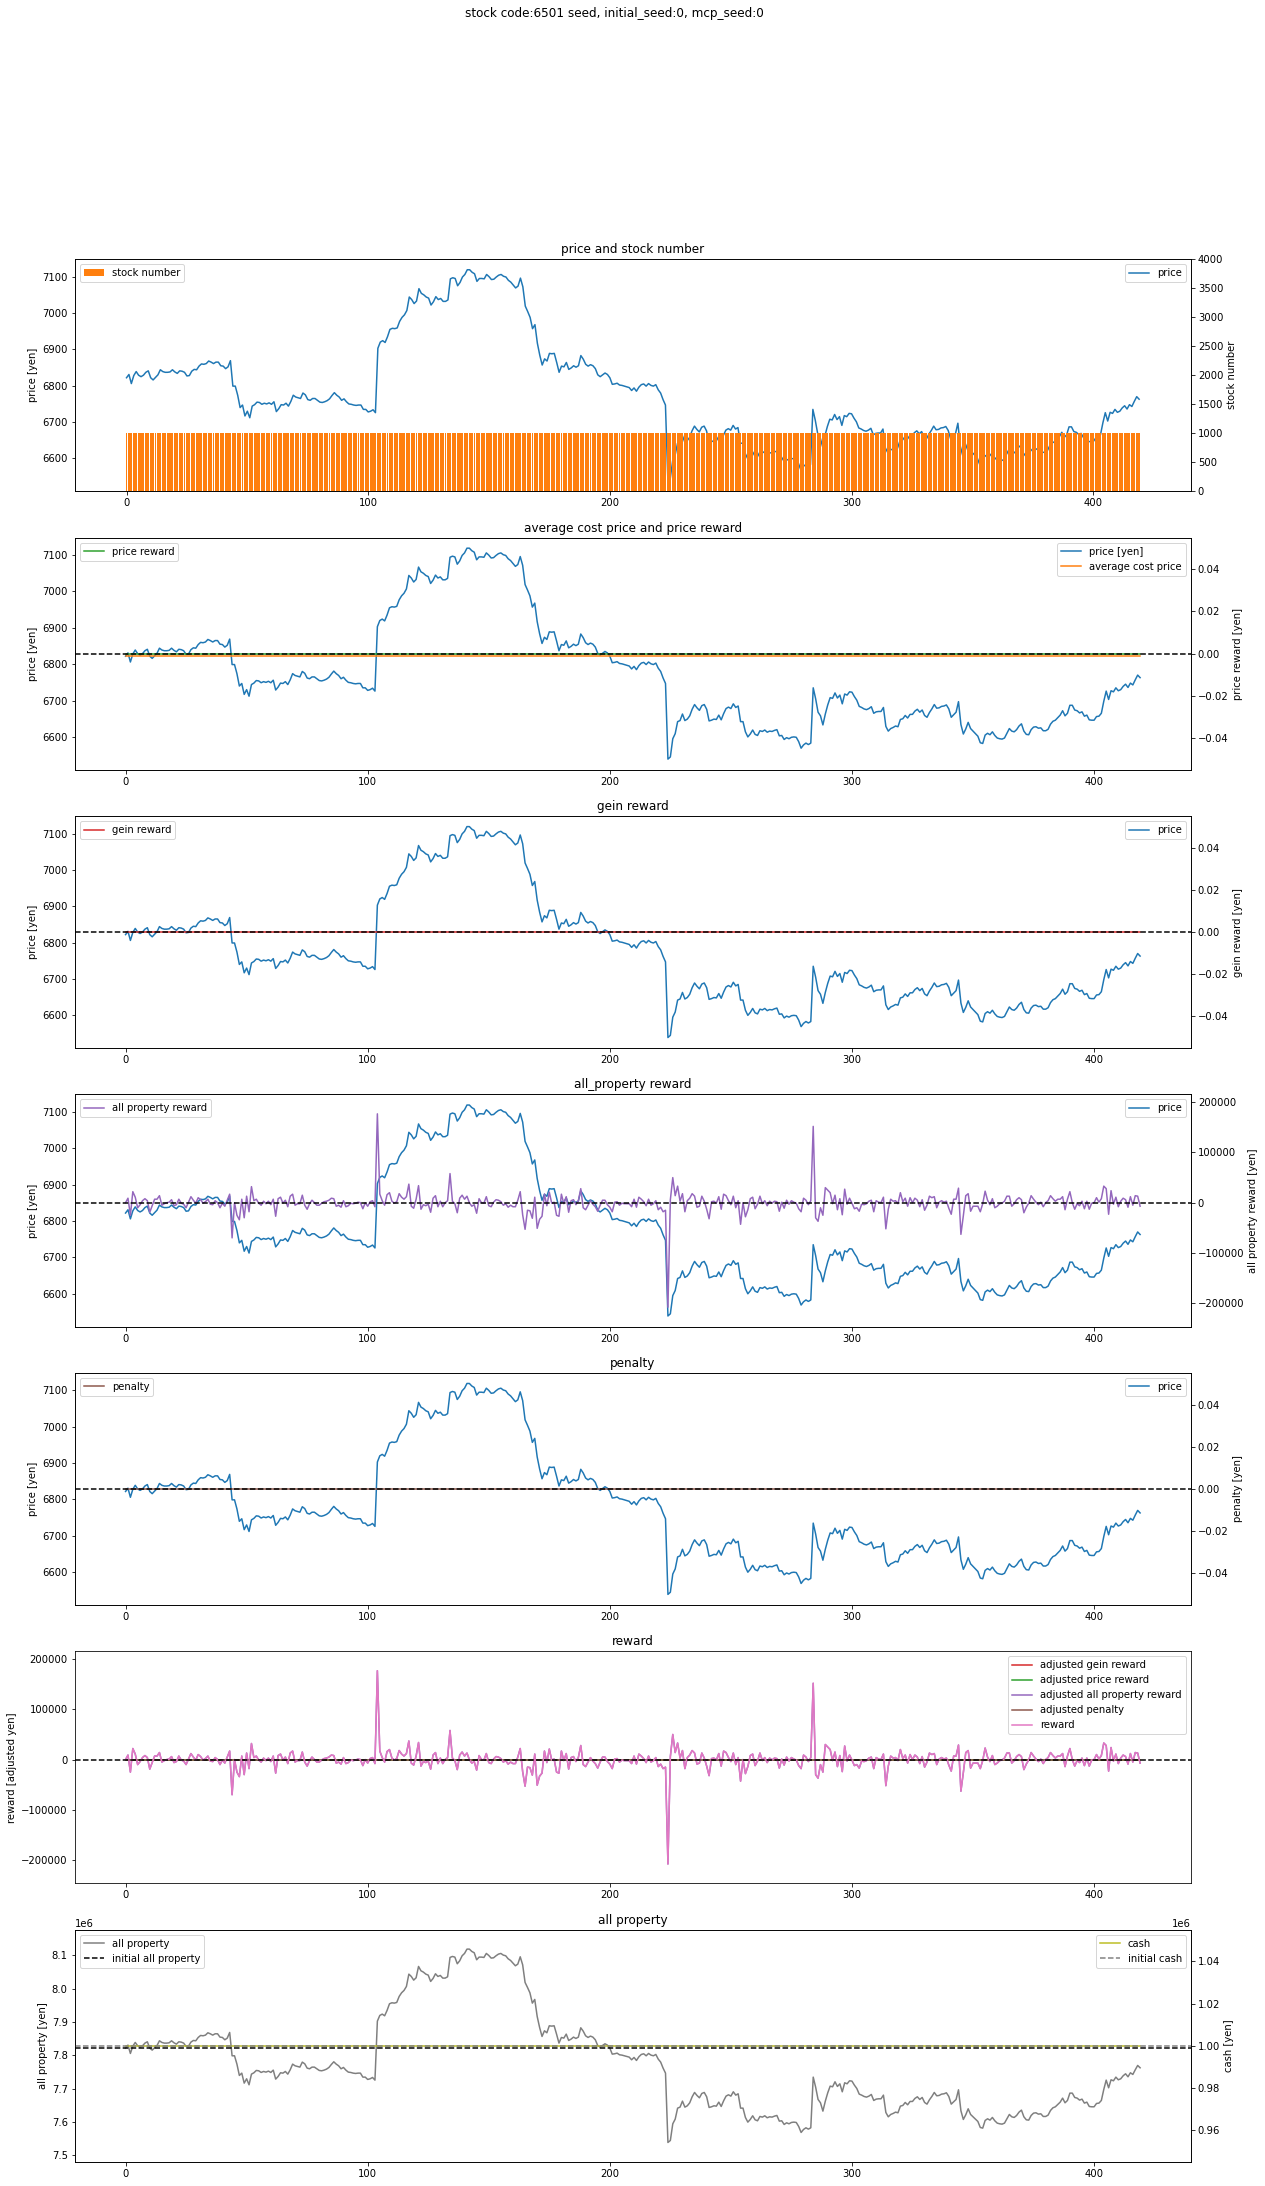

In [62]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(20,35))
ax1 = fig.add_subplot(711)

# figureのタイトル
fig.suptitle("stock code:{} seed, initial_seed:{}, mcp_seed:{}".format("6501","0","0"))

# 価格の描画
x = np.arange(0,len(state_list))
ax1.plot(x, price_array, zorder=1, label="price")
ax1.set_ylabel("price [yen]")
ax1.set_title("price and stock number")

ax2 = ax1.twinx()
ax2.bar(x, stock_number_array, color="C1", zorder=2, label="stock number")
ax2.set_ylabel("stock number")
ax2.set_ylim(min(0,2*np.amin(stock_number_array)), 4*np.amax(stock_number_array))


# 価格・平均取得価格，price_reward
ax3 = fig.add_subplot(712)
ax3.plot(x, price_array, zorder=1, label="price [yen]")
ax3.plot(x, mean_cost_price_array, zorder=1, label="average cost price")
ax3.set_ylabel("price [yen]")
ax3.set_title("average cost price and price reward")

ax4 = ax3.twinx()
ax4.plot(x, price_reward_array, zorder=1, label="price reward", color="C2")
ax4.axhline(y=0, color="black", linestyle="dashed")
ax4.set_ylabel("price reward [yen]")

y_min, y_max = make_y_limit(price_reward_array)
if y_min != y_max:
    ax4.set_ylim(y_min,y_max)

# 価格, gein_reward
ax5 = fig.add_subplot(713)
ax5.plot(x, price_array, label="price", color="C0")
ax5.set_ylabel("price [yen]")
ax5.set_title("gein reward")

ax6 = ax5.twinx()
ax6.plot(x, gein_reward_array, label="gein reward", color="C3")
ax6.set_ylabel("gein reward [yen]")
ax6.axhline(y=0, color="black", linestyle="dashed")

y_min, y_max = make_y_limit(gein_reward_array)
if y_min != y_max:
    ax6.set_ylim(y_min, y_max)

# 価格，all_property_reward
ax7 = fig.add_subplot(714)
ax7.plot(x, price_array, label="price", color="C0")
ax7.set_ylabel("price [yen]")
ax7.set_title("all_property reward")

ax8 = ax7.twinx()
ax8.plot(x, all_property_reward_array, label="all property reward", color="C4")
ax8.set_ylabel("all property reward [yen]")
ax8.axhline(y=0, color="black", linestyle="dashed")

y_min, y_max = make_y_limit(all_property_reward_array)
if y_min != y_max:
    ax8.set_ylim(y_min, y_max)

# 価格，ペナルティ
ax9 = fig.add_subplot(715)
ax9.plot(x, price_array, label="price", color="C0")
ax9.set_ylabel("price [yen]")
ax9.set_title("penalty")

ax10 = ax9.twinx()
ax10.plot(x, penalty_array, label="penalty", color="C5")
ax10.set_ylabel("penalty [yen]")
ax10.axhline(y=0, color="black", linestyle="dashed")


# 報酬，取引報酬(調整済み)，価格報酬(調整済み)，全資産報酬 ，報酬, ペナルティ
ax11 = fig.add_subplot(716)
ax11.plot(x, adjusted_gein_reward_array, label="adjusted gein reward", color="C3")
ax11.plot(x, adjusted_price_reward_array, label="adjusted price reward", color="C2")
ax11.plot(x, adjusted_all_property_reward_array, label="adjusted all property reward", color="C4")
ax11.plot(x, adjusted_penalty_array, label="adjusted penalty", color="C5")
ax11.plot(x, reward_array, label="reward", color="C6")
ax11.axhline(y=0, color="black", linestyle="dashed")

gein_y_min, gein_y_max = make_y_limit(adjusted_gein_reward_array)
price_y_min, price_y_max = make_y_limit(adjusted_price_reward_array)
all_pernalty_y_min, all_pernalty_y_max = make_y_limit(adjusted_all_property_reward_array)
reward_y_min, reward_y_max = make_y_limit(reward_array)

y_min = min(gein_y_min, price_y_min, all_pernalty_y_min)  # rewardは含めない
y_max = max(gein_y_max, price_y_max, all_pernalty_y_max, reward_y_max)  # rewardも含める
if y_min != y_max:
    ax11.set_ylim(y_min, y_max)
ax11.set_ylabel("reward [adjusted yen]")
ax11.set_title("reward")

# 全財産・現金の推移
ax12 = fig.add_subplot(717)
ax12.plot(x, all_property_array, color="C7", label="all property")
ax12.axhline(y=all_property_array[0], color="black", linestyle="dashed", label="initial all property")
ax12.set_ylabel("all property [yen]")
y_min, y_max = make_y_limit(all_property_array)
if y_min != y_max:
    ax12.set_ylim(y_min, y_max)

ax13 = ax12.twinx()
ax13.plot(x, cash_array, color="C8", label="cash")
ax13.axhline(y=cash_array[0], color="gray", linestyle="dashed", label="initial cash")
ax13.set_ylabel("cash [yen]")
ax13.set_title("all property")

# 凡例の表示
ax1.legend(loc="upper right")
ax2.legend(loc="upper left")
ax3.legend(loc="upper right")
ax4.legend(loc="upper left")
ax5.legend(loc="upper right")
ax6.legend(loc="upper left")
ax7.legend(loc="upper right")
ax8.legend(loc="upper left")
ax9.legend(loc="upper right")
ax10.legend(loc="upper left")

ax11.legend(loc="upper right")

ax12.legend(loc="upper left")
ax13.legend(loc="upper right")

#### bokehで描画

In [38]:
from bokeh.io import output_notebook, show
import bokeh.plotting
import bokeh.layouts
output_notebook()

from bokeh.models import LinearAxis, Range1d, Div

Loading BokehJS ...

In [59]:
#bokeh color like matplotlib
bokeh_colors = {"C0":"steelblue","C1":"darkorange","C2":"mediumseagreen","C3":"firebrick","C4":"mediumslateblue",
                "C5":"maroon","C6":"palevioletred","C7":"lightslategray","C8":"olive","C9":"darkturquoise"}

# 価格，保有量
p1 = bokeh.plotting.figure(plot_width=1200,plot_height=300,title="価格・保有量")

p1.extra_y_ranges = {"stock_number": Range1d(start=min(0,2*np.amin(stock_number_array)), end=4*np.amax(stock_number_array))}
p1.add_layout(LinearAxis(y_range_name="stock_number"), 'right')
p1.vbar(x=x,top=stock_number_array,y_range_name="stock_number",fill_color=bokeh_colors["C1"],line_color=bokeh_colors["C1"],legend_label="stock number")

p1.line(x=x,y=price_array,line_color=bokeh_colors["C0"],line_width=2,legend_label="price")
y_min, y_max = make_y_limit(price_array)
p1.y_range = Range1d(start=y_min,end=y_max)

p1.yaxis[0].axis_label = "価格 [円]"
p1.yaxis[1].axis_label = "保有量"

# 価格・平均取得価格，price_reward
p2 = bokeh.plotting.figure(plot_width=1200,plot_height=300,title="平均取得価格・平均取得価格による報酬")
p2.line(x=x,y=price_array,line_color=bokeh_colors["C0"],line_width=2,legend_label="price")
p2.line(x=x,y=mean_cost_price_array,line_color=bokeh_colors["C1"],line_width=2,legend_label="average cost price")
y_min, y_max = make_y_limit(price_array)
p2.y_range = Range1d(start=y_min,end=y_max)

y_min, y_max = make_y_limit(price_reward_array)
p2.extra_y_ranges = {"reward": Range1d(start=y_min,end=y_max)}
p2.add_layout(LinearAxis(y_range_name="reward"), 'right')
p2.line(x=x,y=price_reward_array,line_color=bokeh_colors["C2"],line_width=2,legend_label="price reward",y_range_name="reward")
#p2.line(x=x,y=penalty_array,line_color=bokeh_colors["C3"],line_width=2,legend_label="penalty",y_range_name="reward")
p2.line(x=[0,len(x)],y=[0,0],line_color="black",line_width=2,line_dash="dashed",y_range_name="reward")

p2.yaxis[0].axis_label = "価格 [円]"
p2.yaxis[1].axis_label = "報酬(無調整) [円]"

# 価格, gein_reward
p3 = bokeh.plotting.figure(plot_width=1200,plot_height=300,title="取引報酬")
p3.line(x=x,y=price_array,line_color=bokeh_colors["C0"],line_width=2,legend_label="price")
y_min, y_max = make_y_limit(price_array)
p3.y_range = Range1d(start=y_min,end=y_max)

y_min, y_max = make_y_limit(gein_reward_array)
p3.extra_y_ranges = {"reward": Range1d(start=y_min,end=y_max)}
p3.add_layout(LinearAxis(y_range_name="reward"), 'right')
p3.line(x=x,y=gein_reward_array,line_color=bokeh_colors["C3"],line_width=2,legend_label="gein reward",y_range_name="reward")
#p3.line(x=x,y=penalty_array,line_color=bokeh_colors["C3"],line_width=2,legend_label="penalty",y_range_name="reward")
p3.line(x=[0,len(x)],y=[0,0],line_color="black",line_width=2,line_dash="dashed",y_range_name="reward")

p3.yaxis[0].axis_label = "価格 [円]"
p3.yaxis[1].axis_label = "報酬(無調整) [円]"

# 価格，all_property_reward
p4 = bokeh.plotting.figure(plot_width=1200,plot_height=300,title="全資産報酬")
p4.line(x=x,y=price_array,line_color=bokeh_colors["C0"],line_width=2,legend_label="price")
y_min, y_max = make_y_limit(price_array)
p4.y_range = Range1d(start=y_min,end=y_max)

y_min, y_max = make_y_limit(all_property_reward_array)
p4.extra_y_ranges = {"reward": Range1d(start=y_min,end=y_max)}
p4.add_layout(LinearAxis(y_range_name="reward"), 'right')
p4.line(x=x,y=all_property_reward_array,line_color=bokeh_colors["C4"],line_width=2,legend_label="all property reward",y_range_name="reward")
p4.line(x=[0,len(x)],y=[0,0],line_color="black",line_width=2,line_dash="dashed",y_range_name="reward")

p4.yaxis[0].axis_label = "価格 [円]"
p4.yaxis[1].axis_label = "報酬(無調整) [円]"

# 価格，ペナルティ
p5 = bokeh.plotting.figure(plot_width=1200,plot_height=300,title="ペナルティ")
p5.line(x=x,y=price_array,line_color=bokeh_colors["C0"],line_width=2,legend_label="price")
y_min, y_max = make_y_limit(price_array)
p5.y_range = Range1d(start=y_min,end=y_max)

y_min, y_max = make_y_limit(penalty_array)
p5.extra_y_ranges = {"penalty": Range1d(start=y_min,end=y_max)}
p5.add_layout(LinearAxis(y_range_name="penalty"), 'right')
p5.line(x=x,y=penalty_array,line_color=bokeh_colors["C5"],line_width=2,legend_label="penalty",y_range_name="penalty")
p5.line(x=[0,len(x)],y=[0,0],line_color="black",line_width=2,line_dash="dashed",y_range_name="penalty")

p5.yaxis[0].axis_label = "価格 [円]"
p5.yaxis[1].axis_label = "ペナルティ(無調整) [円]"

# 報酬，取引報酬(調整済み)，価格報酬(調整済み)，全資産報酬 ，報酬, ペナルティ
p6 = bokeh.plotting.figure(plot_width=1200,plot_height=300,title="全体報酬・調整済み各報酬")
p6.line(x=x,y=adjusted_gein_reward_array,line_color=bokeh_colors["C3"],line_width=2,legend_label="adjusted gein reward")
p6.line(x=x,y=adjusted_price_reward_array,line_color=bokeh_colors["C2"],line_width=2,legend_label="adjusted price reward")
p6.line(x=x,y=adjusted_all_property_reward_array,line_color=bokeh_colors["C4"],line_width=2,legend_label="adjusted all property reward")
p6.line(x=x,y=reward_array,line_color=bokeh_colors["C6"],line_width=2,legend_label="reward")
p6.line(x=[0,len(x)],y=[0,0],line_color="black",line_width=2,line_dash="dashed")
p6.line(x=x,y=adjusted_penalty_array,line_color=bokeh_colors["C5"],line_width=2,legend_label="adjusted penalty")

gein_y_min, gein_y_max = make_y_limit(adjusted_gein_reward_array)
price_y_min, price_y_max = make_y_limit(adjusted_price_reward_array)
all_pernalty_y_min, all_pernalty_y_max = make_y_limit(adjusted_all_property_reward_array)
reward_y_min, reward_y_max = make_y_limit(reward_array)

y_min = min(gein_y_min, price_y_min, all_pernalty_y_min)  # rewardは含めない
y_max = max(gein_y_max, price_y_max, all_pernalty_y_max, reward_y_max)  # rewardも含める
p6.y_range = Range1d(start=y_min, end=y_max)

p6.yaxis[0].axis_label = "報酬(調整) [円]"

# 全財産・現金の推移
p7 = bokeh.plotting.figure(plot_width=1200,plot_height=300,title="全財産")
p7.line(x=x,y=all_property_array,line_color=bokeh_colors["C7"],line_width=2,legend_label="all property")
p7.line(x=[0,len(x)],y=[all_property_array[0],all_property_array[0]],line_color="black",line_width=2,line_dash="dashed",legend_label="initial all property")
y_min, y_max = make_y_limit(all_property_array)
p7.y_range = Range1d(start=y_min, end=y_max)

y_min, y_max = make_y_limit(cash_array)
p7.extra_y_ranges = {"cash": Range1d(start=y_min,end=y_max)}
p7.add_layout(LinearAxis(y_range_name="cash"), 'right')
p7.line(x=x,y=cash_array,line_color=bokeh_colors["C8"],line_width=2,legend_label="cash",y_range_name="cash")
p7.line(x=[0,len(x)],y=[cash_array[0],cash_array[0]],line_color="gray",line_width=2,line_dash="dashed",y_range_name="cash",legend_label="initial cash")

p7.yaxis[0].axis_label = "全財産 [円]"
p7.yaxis[1].axis_label = "現金 [円]"

sup_title = Div(text="銘柄コード:{} initial_seed:{}, mcp_seed:{}".format("6501","0","0"))
created_figure = bokeh.layouts.column(sup_title,p1,p2,p3,p4,p5,p6,p7)

show(created_figure)

### matplotlibによる売買仮定の描画関数 

In [66]:
def plot_trading_process_matplotlib(state_list, info_list, env, title=None, save_path=None, is_save=True):
    # データの取り出し
    cash_array = np.array(list(map(lambda state: state.cash, state_list)))
    price_array = np.array(list(map(lambda state: state.now_price, state_list)))
    stock_number_array = np.array(list(map(lambda state: state.unit_number*env.one_unit_stocks, state_list)))
    all_property_array = np.array(list(map(lambda state: state.all_property, state_list)))
    price_reward_array = np.array(list(map(lambda info: info["price_reward"], info_list)))
    gein_reward_array = np.array(list(map(lambda info: info["gein_reward"], info_list)))
    all_property_reward_array = np.array(list(map(lambda info: info["all_property_reward"], info_list)))
    penalty_array = np.array(list(map(lambda info: info["penalty"], info_list)))
    reward_array = np.array(list(map(lambda info: info["reward"], info_list)))
    mean_cost_price_array = np.array(list(map(lambda state: state.mean_cost_price, state_list)))
    adjusted_gein_reward_array = np.array(list(map(lambda info: info["gein_reward"]*env.gein_reward_weight, info_list)))
    adjusted_price_reward_array = np.array(list(map(lambda info: info["price_reward"]*env.price_reward_weight, info_list)))
    adjusted_all_property_reward_array = np.array(list(map(lambda info: info["all_property_reward"]*env.all_property_reward_weight, info_list)))
    adjusted_penalty_array = np.array(list(map(lambda info: info["penalty"]*env.penalty_weight, info_list))) 

    x = np.arange(0,len(state_list))
    
    fig = plt.figure(figsize=(20,35))
    ax1 = fig.add_subplot(711)
    
    # figureのタイトル
    fig.suptitle(title)
    
    # 価格の描画
    x = np.arange(0,len(state_list))
    ax1.plot(x, price_array, zorder=1, label="price")
    ax1.set_ylabel("price [yen]")
    ax1.set_title("price and stock number")

    ax2 = ax1.twinx()
    ax2.bar(x, stock_number_array, color="C1", zorder=2, label="stock number")
    ax2.set_ylabel("stock number")
    ax2.set_ylim(min(0,2*np.amin(stock_number_array)), 4*np.amax(stock_number_array))


    # 価格・平均取得価格，price_reward
    ax3 = fig.add_subplot(712)
    ax3.plot(x, price_array, zorder=1, label="price [yen]")
    ax3.plot(x, mean_cost_price_array, zorder=1, label="average cost price")
    ax3.set_ylabel("price [yen]")
    ax3.set_title("average cost price and price reward")

    ax4 = ax3.twinx()
    ax4.plot(x, price_reward_array, zorder=1, label="price reward", color="C2")
    ax4.axhline(y=0, color="black", linestyle="dashed")
    ax4.set_ylabel("price reward [yen]")

    y_min, y_max = make_y_limit(price_reward_array)
    if y_min != y_max:
        ax4.set_ylim(y_min,y_max)

    # 価格, gein_reward
    ax5 = fig.add_subplot(713)
    ax5.plot(x, price_array, label="price", color="C0")
    ax5.set_ylabel("price [yen]")
    ax5.set_title("gein reward")

    ax6 = ax5.twinx()
    ax6.plot(x, gein_reward_array, label="gein reward", color="C3")
    ax6.set_ylabel("gein reward [yen]")
    ax6.axhline(y=0, color="black", linestyle="dashed")

    y_min, y_max = make_y_limit(gein_reward_array)
    if y_min != y_max:
        ax6.set_ylim(y_min, y_max)

    # 価格，all_property_reward
    ax7 = fig.add_subplot(714)
    ax7.plot(x, price_array, label="price", color="C0")
    ax7.set_ylabel("price [yen]")
    ax7.set_title("all_property reward")

    ax8 = ax7.twinx()
    ax8.plot(x, all_property_reward_array, label="all property reward", color="C4")
    ax8.set_ylabel("all property reward [yen]")
    ax8.axhline(y=0, color="black", linestyle="dashed")

    y_min, y_max = make_y_limit(all_property_reward_array)
    if y_min != y_max:
        ax8.set_ylim(y_min, y_max)

    # 価格，ペナルティ
    ax9 = fig.add_subplot(715)
    ax9.plot(x, price_array, label="price", color="C0")
    ax9.set_ylabel("price [yen]")
    ax9.set_title("penalty")

    ax10 = ax9.twinx()
    ax10.plot(x, penalty_array, label="penalty", color="C5")
    ax10.set_ylabel("penalty [yen]")
    ax10.axhline(y=0, color="black", linestyle="dashed")


    # 報酬，取引報酬(調整済み)，価格報酬(調整済み)，全資産報酬 ，報酬, ペナルティ
    ax11 = fig.add_subplot(716)
    ax11.plot(x, adjusted_gein_reward_array, label="adjusted gein reward", color="C3")
    ax11.plot(x, adjusted_price_reward_array, label="adjusted price reward", color="C2")
    ax11.plot(x, adjusted_all_property_reward_array, label="adjusted all property reward", color="C4")
    ax11.plot(x, adjusted_penalty_array, label="adjusted penalty", color="C5")
    ax11.plot(x, reward_array, label="reward", color="C6")
    ax11.axhline(y=0, color="black", linestyle="dashed")

    gein_y_min, gein_y_max = make_y_limit(adjusted_gein_reward_array)
    price_y_min, price_y_max = make_y_limit(adjusted_price_reward_array)
    all_pernalty_y_min, all_pernalty_y_max = make_y_limit(adjusted_all_property_reward_array)
    reward_y_min, reward_y_max = make_y_limit(reward_array)

    y_min = min(gein_y_min, price_y_min, all_pernalty_y_min)  # rewardは含めない
    y_max = max(gein_y_max, price_y_max, all_pernalty_y_max, reward_y_max)  # rewardも含める
    if y_min != y_max:
        ax11.set_ylim(y_min, y_max)
    ax11.set_ylabel("reward [adjusted yen]")
    ax11.set_title("reward")

    # 全財産・現金の推移
    ax12 = fig.add_subplot(717)
    ax12.plot(x, all_property_array, color="C7", label="all property")
    ax12.axhline(y=all_property_array[0], color="black", linestyle="dashed", label="initial all property")
    ax12.set_ylabel("all property [yen]")
    y_min, y_max = make_y_limit(all_property_array)
    if y_min != y_max:
        ax12.set_ylim(y_min, y_max)

    ax13 = ax12.twinx()
    ax13.plot(x, cash_array, color="C8", label="cash")
    ax13.axhline(y=cash_array[0], color="gray", linestyle="dashed", label="initial cash")
    ax13.set_ylabel("cash [yen]")
    ax13.set_title("all property")

    # 凡例の表示
    ax1.legend(loc="upper right")
    ax2.legend(loc="upper left")
    ax3.legend(loc="upper right")
    ax4.legend(loc="upper left")
    ax5.legend(loc="upper right")
    ax6.legend(loc="upper left")
    ax7.legend(loc="upper right")
    ax8.legend(loc="upper left")
    ax9.legend(loc="upper right")
    ax10.legend(loc="upper left")

    ax11.legend(loc="upper right")

    ax12.legend(loc="upper left")
    ax13.legend(loc="upper right")
    
    if is_save:
        fig.savefig(save_path,bbox_inches='tight', pad_inches=0)
        plt.close()
    else:
        plt.show()

### bokeh による売買過程の描画関数

In [67]:
def plot_trading_process_bokeh(state_list, info_list, env, title=None, save_path=None, is_save=True, is_html=False):
    # データの取り出し
    cash_array = np.array(list(map(lambda state: state.cash, state_list)))
    price_array = np.array(list(map(lambda state: state.now_price, state_list)))
    stock_number_array = np.array(list(map(lambda state: state.unit_number*env.one_unit_stocks, state_list)))
    all_property_array = np.array(list(map(lambda state: state.all_property, state_list)))
    price_reward_array = np.array(list(map(lambda info: info["price_reward"], info_list)))
    gein_reward_array = np.array(list(map(lambda info: info["gein_reward"], info_list)))
    all_property_reward_array = np.array(list(map(lambda info: info["all_property_reward"], info_list)))
    penalty_array = np.array(list(map(lambda info: info["penalty"], info_list)))
    reward_array = np.array(list(map(lambda info: info["reward"], info_list)))
    mean_cost_price_array = np.array(list(map(lambda state: state.mean_cost_price, state_list)))
    adjusted_gein_reward_array = np.array(list(map(lambda info: info["gein_reward"]*env.gein_reward_weight, info_list)))
    adjusted_price_reward_array = np.array(list(map(lambda info: info["price_reward"]*env.price_reward_weight, info_list)))
    adjusted_all_property_reward_array = np.array(list(map(lambda info: info["all_property_reward"]*env.all_property_reward_weight, info_list)))
    adjusted_penalty_array = np.array(list(map(lambda info: info["penalty"]*env.penalty_weight, info_list))) 

    x = np.arange(0,len(state_list))
    
    # 描画・保存

    # 価格，保有量
    p1 = bokeh.plotting.figure(plot_width=1200,plot_height=300,title="価格・保有量")

    p1.extra_y_ranges = {"stock_number": Range1d(start=min(0,2*np.amin(stock_number_array)), end=4*np.amax(stock_number_array))}
    p1.add_layout(LinearAxis(y_range_name="stock_number"), 'right')
    p1.vbar(x=x,top=stock_number_array,y_range_name="stock_number",fill_color=bokeh_colors["C1"],line_color=bokeh_colors["C1"],legend_label="stock number")

    p1.line(x=x,y=price_array,line_color=bokeh_colors["C0"],line_width=2,legend_label="price")
    y_min, y_max = make_y_limit(price_array)
    p1.y_range = Range1d(start=y_min,end=y_max)

    p1.yaxis[0].axis_label = "価格 [円]"
    p1.yaxis[1].axis_label = "保有量"

    # 価格・平均取得価格，price_reward
    p2 = bokeh.plotting.figure(plot_width=1200,plot_height=300,title="平均取得価格・平均取得価格による報酬")
    p2.line(x=x,y=price_array,line_color=bokeh_colors["C0"],line_width=2,legend_label="price")
    p2.line(x=x,y=mean_cost_price_array,line_color=bokeh_colors["C1"],line_width=2,legend_label="average cost price")
    y_min, y_max = make_y_limit(price_array)
    p2.y_range = Range1d(start=y_min,end=y_max)

    y_min, y_max = make_y_limit(price_reward_array)
    p2.extra_y_ranges = {"reward": Range1d(start=y_min,end=y_max)}
    p2.add_layout(LinearAxis(y_range_name="reward"), 'right')
    p2.line(x=x,y=price_reward_array,line_color=bokeh_colors["C2"],line_width=2,legend_label="price reward",y_range_name="reward")
    #p2.line(x=x,y=penalty_array,line_color=bokeh_colors["C3"],line_width=2,legend_label="penalty",y_range_name="reward")
    p2.line(x=[0,len(x)],y=[0,0],line_color="black",line_width=2,line_dash="dashed",y_range_name="reward")

    p2.yaxis[0].axis_label = "価格 [円]"
    p2.yaxis[1].axis_label = "報酬(無調整) [円]"

    # 価格, gein_reward
    p3 = bokeh.plotting.figure(plot_width=1200,plot_height=300,title="取引報酬")
    p3.line(x=x,y=price_array,line_color=bokeh_colors["C0"],line_width=2,legend_label="price")
    y_min, y_max = make_y_limit(price_array)
    p3.y_range = Range1d(start=y_min,end=y_max)

    y_min, y_max = make_y_limit(gein_reward_array)
    p3.extra_y_ranges = {"reward": Range1d(start=y_min,end=y_max)}
    p3.add_layout(LinearAxis(y_range_name="reward"), 'right')
    p3.line(x=x,y=gein_reward_array,line_color=bokeh_colors["C3"],line_width=2,legend_label="gein reward",y_range_name="reward")
    #p3.line(x=x,y=penalty_array,line_color=bokeh_colors["C3"],line_width=2,legend_label="penalty",y_range_name="reward")
    p3.line(x=[0,len(x)],y=[0,0],line_color="black",line_width=2,line_dash="dashed",y_range_name="reward")

    p3.yaxis[0].axis_label = "価格 [円]"
    p3.yaxis[1].axis_label = "報酬(無調整) [円]"

    # 価格，all_property_reward
    p4 = bokeh.plotting.figure(plot_width=1200,plot_height=300,title="全資産報酬")
    p4.line(x=x,y=price_array,line_color=bokeh_colors["C0"],line_width=2,legend_label="price")
    y_min, y_max = make_y_limit(price_array)
    p4.y_range = Range1d(start=y_min,end=y_max)

    y_min, y_max = make_y_limit(all_property_reward_array)
    p4.extra_y_ranges = {"reward": Range1d(start=y_min,end=y_max)}
    p4.add_layout(LinearAxis(y_range_name="reward"), 'right')
    p4.line(x=x,y=all_property_reward_array,line_color=bokeh_colors["C4"],line_width=2,legend_label="all property reward",y_range_name="reward")
    p4.line(x=[0,len(x)],y=[0,0],line_color="black",line_width=2,line_dash="dashed",y_range_name="reward")

    p4.yaxis[0].axis_label = "価格 [円]"
    p4.yaxis[1].axis_label = "報酬(無調整) [円]"

    # 価格，ペナルティ
    p5 = bokeh.plotting.figure(plot_width=1200,plot_height=300,title="ペナルティ")
    p5.line(x=x,y=price_array,line_color=bokeh_colors["C0"],line_width=2,legend_label="price")
    y_min, y_max = make_y_limit(price_array)
    p5.y_range = Range1d(start=y_min,end=y_max)

    y_min, y_max = make_y_limit(penalty_array)
    p5.extra_y_ranges = {"penalty": Range1d(start=y_min,end=y_max)}
    p5.add_layout(LinearAxis(y_range_name="penalty"), 'right')
    p5.line(x=x,y=penalty_array,line_color=bokeh_colors["C5"],line_width=2,legend_label="penalty",y_range_name="penalty")
    p5.line(x=[0,len(x)],y=[0,0],line_color="black",line_width=2,line_dash="dashed",y_range_name="penalty")

    p5.yaxis[0].axis_label = "価格 [円]"
    p5.yaxis[1].axis_label = "ペナルティ(無調整) [円]"

    # 報酬，取引報酬(調整済み)，価格報酬(調整済み)，全資産報酬 ，報酬, ペナルティ
    p6 = bokeh.plotting.figure(plot_width=1200,plot_height=300,title="全体報酬・調整済み各報酬")
    p6.line(x=x,y=adjusted_gein_reward_array,line_color=bokeh_colors["C3"],line_width=2,legend_label="adjusted gein reward")
    p6.line(x=x,y=adjusted_price_reward_array,line_color=bokeh_colors["C2"],line_width=2,legend_label="adjusted price reward")
    p6.line(x=x,y=adjusted_all_property_reward_array,line_color=bokeh_colors["C4"],line_width=2,legend_label="adjusted all property reward")
    p6.line(x=x,y=reward_array,line_color=bokeh_colors["C6"],line_width=2,legend_label="reward")
    p6.line(x=[0,len(x)],y=[0,0],line_color="black",line_width=2,line_dash="dashed")
    p6.line(x=x,y=adjusted_penalty_array,line_color=bokeh_colors["C5"],line_width=2,legend_label="adjusted penalty")

    gein_y_min, gein_y_max = make_y_limit(adjusted_gein_reward_array)
    price_y_min, price_y_max = make_y_limit(adjusted_price_reward_array)
    all_pernalty_y_min, all_pernalty_y_max = make_y_limit(adjusted_all_property_reward_array)
    reward_y_min, reward_y_max = make_y_limit(reward_array)

    y_min = min(gein_y_min, price_y_min, all_pernalty_y_min)  # rewardは含めない
    y_max = max(gein_y_max, price_y_max, all_pernalty_y_max, reward_y_max)  # rewardも含める
    p6.y_range = Range1d(start=y_min, end=y_max)

    p6.yaxis[0].axis_label = "報酬(調整) [円]"

    # 全財産・現金の推移
    p7 = bokeh.plotting.figure(plot_width=1200,plot_height=300,title="全財産")
    p7.line(x=x,y=all_property_array,line_color=bokeh_colors["C7"],line_width=2,legend_label="all property")
    p7.line(x=[0,len(x)],y=[all_property_array[0],all_property_array[0]],line_color="black",line_width=2,line_dash="dashed",legend_label="initial all property")
    y_min, y_max = make_y_limit(all_property_array)
    p7.y_range = Range1d(start=y_min, end=y_max)

    y_min, y_max = make_y_limit(cash_array)
    p7.extra_y_ranges = {"cash": Range1d(start=y_min,end=y_max)}
    p7.add_layout(LinearAxis(y_range_name="cash"), 'right')
    p7.line(x=x,y=cash_array,line_color=bokeh_colors["C8"],line_width=2,legend_label="cash",y_range_name="cash")
    p7.line(x=[0,len(x)],y=[cash_array[0],cash_array[0]],line_color="gray",line_width=2,line_dash="dashed",y_range_name="cash",legend_label="initial cash")

    p7.yaxis[0].axis_label = "全財産 [円]"
    p7.yaxis[1].axis_label = "現金 [円]"

    if title is not None:
        sup_title = Div(text=title)
        created_figure = bokeh.layouts.column(sup_title,p1,p2,p3,p4,p5,p6,p7)
    else:
        created_figure = bokeh.layouts.column(p1,p2,p3,p4,p5,p6,p7)
    
    if is_save:
        if not is_html:
            if save_path.suffix != ".png":
                raise Exception("%save_name suffix must be png")
            bokeh.io.export_png(created_figure, filename=save_path)
        else:
            if save_path.suffix != ".html":
                raise Exception("save_path suffix must be html")
            bokeh.io.save(created_figure, filename=save_path, title="trading process")
    else:
        show(created_figure)

In [68]:
save_path = Path("tradng_process_figures/trading_process_bokeh.png")
plot_trading_process_bokeh(state_list, 
                           info_list,
                           env,
                           title="銘柄コード:{} initial_seed:{}, mcp_seed:{}".format("6501","0","0"),
                           save_path=save_path,
                           is_save=False,
                           is_html=False)

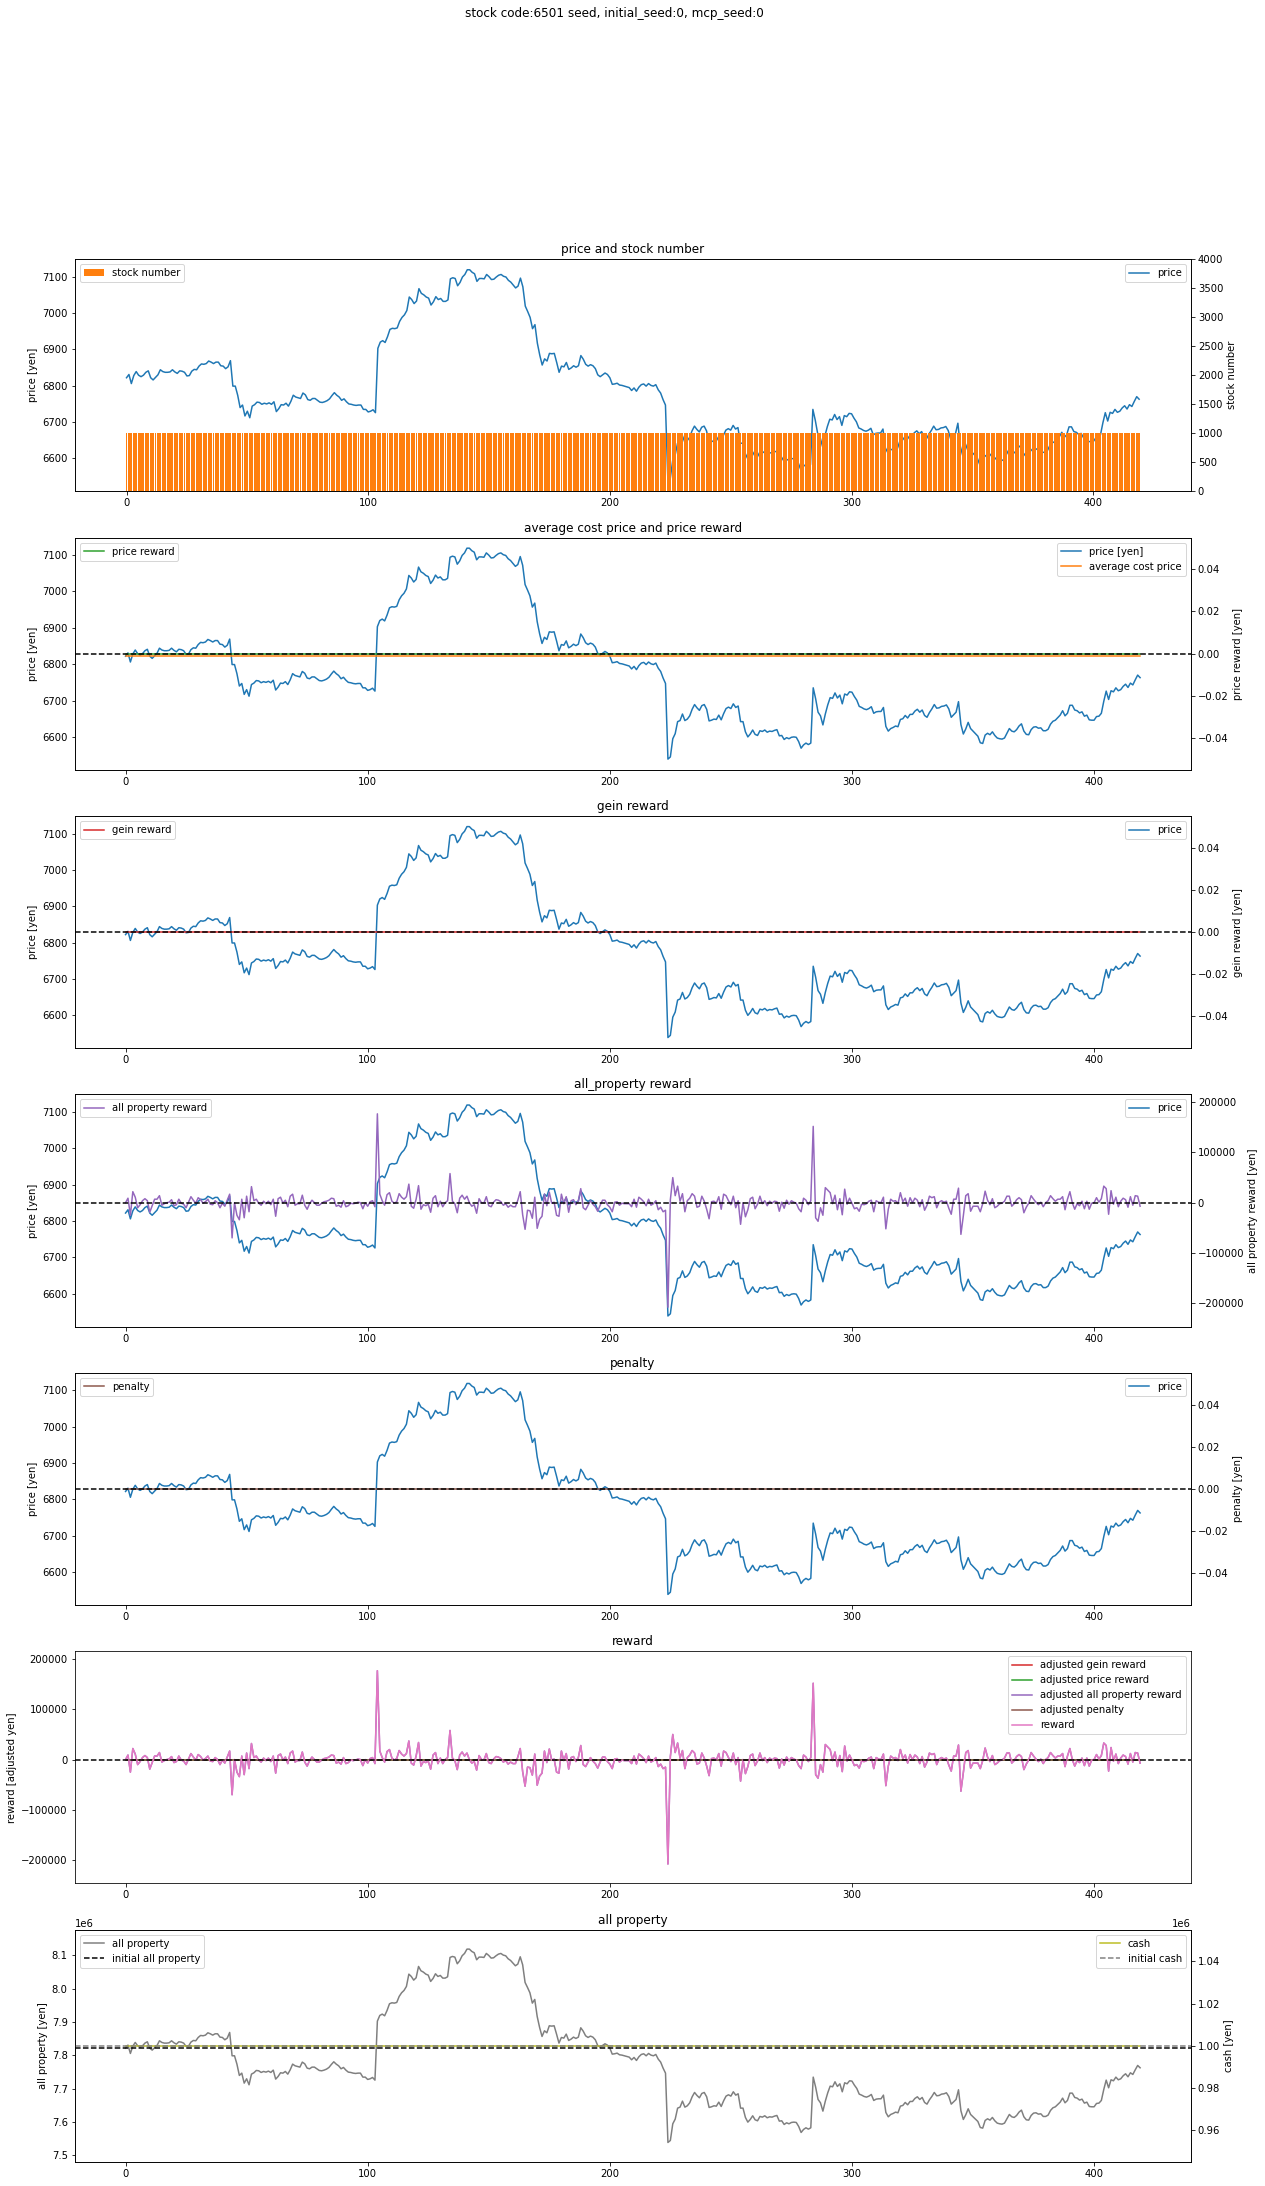

In [69]:
save_path = Path("tradng_process_figures/trading_process_matplotlib.png")
plot_trading_process_matplotlib(state_list,
                                info_list,
                                env,
                                title="stock code:{} seed, initial_seed:{}, mcp_seed:{}".format("6501","0","0"),
                                save_path=save_path,
                                is_save=False)